<a href="https://colab.research.google.com/github/drew-walkerr/Diss_Detecting_Provider_Bias/blob/main/doubt_marker_rf_svm_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/
# This is the general format I'm going to use for the BOW classifier for the detecting bias project.
import pandas as pd
import numpy
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn import feature_selection
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import MultinomialNB
# Import modules for evaluation purposes
# Import libraries for predcton
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score
import nltk

nltk.download('punkt')
nltk.download('stopwords')


from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score




import torch
torch.cuda.empty_cache()
import seaborn as sns
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import logging
logging.basicConfig(level=logging.ERROR)
from google.colab import output
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

#GPU usage setup
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
import random
random.seed(1)
np.random.seed(1)
torch.cuda.manual_seed(1)
torch.manual_seed(1)




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# mount drive to access data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:

%cd /content/drive/MyDrive/Diss_Detecting_Provider_Bias/Aim 1/Doubt Markers/3_Classification

%ls

/content/drive/MyDrive/Diss_Detecting_Provider_Bias/Aim 1/Doubt Markers/3_Classification
annotation_Drew_sample_doubt_markers.csv  gold_standard_doubt_marker_100.csv
doubt_marker_accuracy.gsheet              gold_standard_doubt_marker_500.csv
doubt_marker_classification.ipynb         predicted_mega.csv
drew_gold_standard_doubt_markers_500.csv  predictions.csv


In [7]:
# Read the Annie Sample csv file
df1 = pd.read_csv("gold_standard_doubt_marker_500.csv") #Annie Sample

# Read the Drew Sample csv file
df2 = pd.read_csv("drew_gold_standard_doubt_markers_500.csv") #Drew Sample
# Bind the rows of the two dataframes
df = pd.concat([df1, df2], ignore_index=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sentence_id   1003 non-null   object 
 1   sentence      997 non-null    object 
 2   matched_term  997 non-null    object 
 3   doubt_label   997 non-null    float64
dtypes: float64(1), object(3)
memory usage: 31.5+ KB


In [8]:
df['label'] = df['doubt_label']
df.drop(['sentence_id','doubt_label'], axis=1)
del df['sentence_id'], df['doubt_label']
# Drop rows with any NaN values
df.dropna(inplace=True)
df.head(3)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 0 to 1002
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sentence      997 non-null    object 
 1   matched_term  997 non-null    object 
 2   label         997 non-null    float64
dtypes: float64(1), object(2)
memory usage: 31.2+ KB


In [9]:
cols = ['sentence', 'matched_term']
df['text'] = df[cols].apply(lambda row: '</s>'.join(row.values.astype(str)), axis=1)
df.head(3)

,sentence,matched_term,label,text
0,"Mom is ambivalent about pumping, and does not ...",\bambivalent\b,1.0,"Mom is ambivalent about pumping, and does not ..."
1,PT ADAMANTLY EXPRESSED THIS IS NOT WHAT SHE WA...,\badamantly\b,0.0,PT ADAMANTLY EXPRESSED THIS IS NOT WHAT SHE WA...
2,believes th Amiodarone extreme tremors Precaut...,\bbelieves\b,1.0,believes th Amiodarone extreme tremors Precaut...


Multinomial Naive Bayes Results
              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88       137
         1.0       0.71      0.89      0.79        62

    accuracy                           0.85       199
   macro avg       0.82      0.86      0.83       199
weighted avg       0.87      0.85      0.85       199

0.8492462311557789


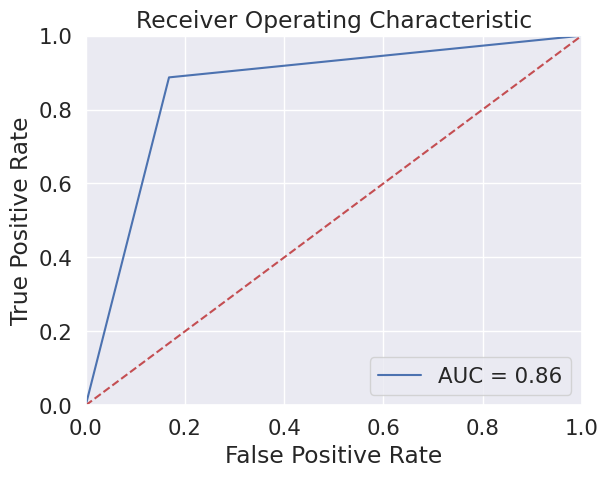

Random Forest Model Results
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       137
         1.0       0.76      0.76      0.76        62

    accuracy                           0.85       199
   macro avg       0.82      0.82      0.82       199
weighted avg       0.85      0.85      0.85       199

0.8492462311557789


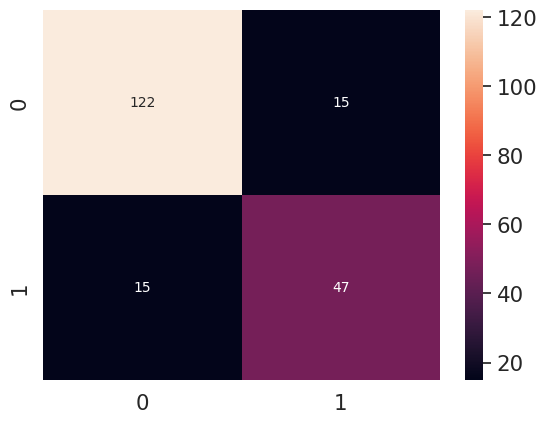

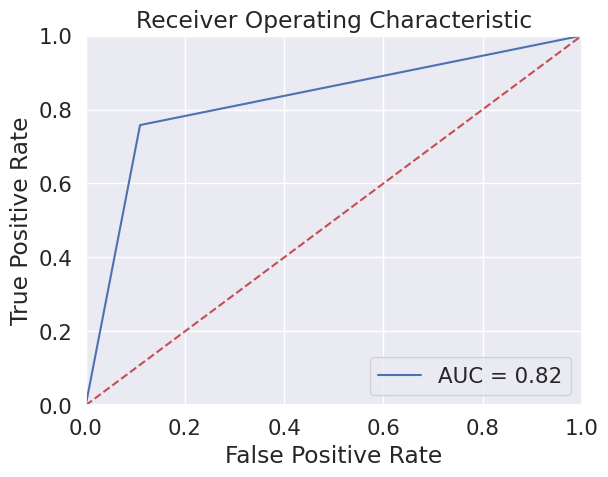

In [20]:
# X_train, X_test, y_train, y_test = train_test_split(gold_standard["Sentence"], gold_standard["quote_use"].values , test_size=0.20, random_state=0)
# Use k-fold
# Show the size of our datasets
# print('X Train Size:',X_train.shape)
# print('X Test Size:',X_test.shape)
skf = StratifiedKFold(n_splits=5)
X = df['text'].values
y = df['label'].values

metrics = []

skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    vect = CountVectorizer(ngram_range=(1, 2), max_features=10000, stop_words="english")
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)

    metrics.append(accuracy_score(y_test, y_pred_class))
    metrics2 = []
# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                         range(cm.shape[1]))
    # plt.figure(figsize = (10,7))
    # Plot the confusion matrix
    sn.set(font_scale=1.4)  # for label size
    sn.heatmap(df_cm, annot=True, fmt='.0f', annot_kws={"size": 10})  # font size
    plt.show()


def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


# try multiple ways of calculating features
# Create the numericalizer TFIDF for lowercase
# tfidf = TfidfTransformer(encoding = "utf-8")
# Numericalize the train dataset
# tf_idf_train = tfidf.fit_transform(X_train.values.astype('U'))
# Numericalize the test dataset
# tf_idf_test = tfidf.transform(X_test.values.astype('U'))

# pipe = Pipeline([('count', CountVectorizer(vocabulary=vocab)),('tfid', TfidfTransformer())]).fit(X_train)

print("Multinomial Naive Bayes Results")
model = MultinomialNB()
model.fit(X_train_dtm, y_train)
y_pred_class2 = model.predict(X_test_dtm)
print(classification_report(y_test,y_pred_class2))
print(accuracy_score(y_test, y_pred_class2))
plot_roc_curve(y_test, y_pred_class2)


print("Random Forest Model Results")

rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(X_train_dtm, y_train)
y_pred_class_rf = rf_model.predict(X_test_dtm)
print(classification_report(y_test,y_pred_class_rf))
print(accuracy_score(y_test, y_pred_class_rf))
plot_confusion_matrix(y_test, y_pred_class_rf)
plot_roc_curve(y_test, y_pred_class_rf)


# BOW MODEL
# 2. Next, for HW 8, write a script that trains a BOW model – could be any non-neural model you
# like. Consider at least two variation of the features of your model—e.g. using counts v. TF-IDF
# representations of your text—rather than two model types. Write up a paragraph describing the
# choices you made in your overleaf doc. Consider the many available tutorials for this sort of thing
# (e.g. here and the sklearn package). Finally, estimate the F1 score and plot a precision/recall
# curve with only one model specification plotted. Consider using a tutorial (e.g. here). Include the
# plot in your write up on overleaf and submit on Canvas.


# clf1 = LogisticRegression(random_state=1)
# clf2 = RandomForestClassifier(random_state=1)
# clf3 = GaussianNB()

# print('5-fold cross validation:\n')

# labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes']

# for clf, label in zip([clf1, clf2, clf3], labels):
#    scores = model_selection.cross_val_score(clf, X_train_dtm, y_train,
#                                             cv=5,
#                                             scoring='accuracy')
#    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
#          % (scores.mean(), scores.std(), label))

# Ensemble voting

# from mlxtend.classifier import EnsembleVoteClassifier

# eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[1, 1, 1])

# labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Ensemble']
# for clf, label in zip([clf1, clf2, clf3, eclf], labels):
#    scores = model_selection.cross_val_score(clf, X_train_dtm, y_train),
#    cv = 5,
#    scoring = 'accuracy'
#    print("Accuracy: %0.2f (+/- %0.2f) [%s]", scores.mean(), scores.std(), label)

In [ ]:
""